# Create a dataset of worldwide cities
This notebook processes several open-source GIS datasets containing relevant information on cities: 
* basic information such as population, geographical region, country, etc.
* population density data from the LandScan project
* nighttime luminosity data from NASA's VIIRS mission
* building density data from the GUF project
* city boundaries from the Census Bureau (US), Urban Atlas/Eurostat (EU), and GDAM (World)

The goal is to create a curated list of _major_ cities world-wide to use in subsequent analysis and machine learning applications.

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point
from matplotlib.patches import Polygon as pltPolygon
from shapely.wkt import loads

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

# satellite imagery modules
import pysatml
from pysatml import satimage as satimg

ModuleNotFoundError: No module named 'pysatml'

In [3]:
# path to save data

outPath = "/home/data/world-cities/"

# paths to input datasets

boundaries_path = "/home/data/city-boundaries/"
population_path = "/home/data/landscan-population/"
luminosity_path = "/home/data/VIIRS/2015/"
bld_sarguf_path = "/home/data/GUF28/"

if not os.path.exists(outPath):
	os.makedirs(outPath)

In [4]:
# some country/city names contain non-ASCII characters encoded as UTF-8

utf8_to_ascii = lambda x: x.decode("utf-8").encode("ascii", "ignore")

# Set up sampling locations

In [12]:
# read in a comprehensive database of world cities
cities_df_all = pd.read_csv(outPath + "worldcitiespop.txt")

# basic filtering 

cities_df_all = cities_df_all[(~cities_df_all.Population.isnull()) & 
                              (~cities_df_all.Latitude.isnull()) & 
                              (~cities_df_all.Longitude.isnull())]
cities_df_all.drop(["Region", "AccentCity"], 1, inplace=True)
cities_df_all.dropna(inplace=True)

# classify cities by population scale
# adapted after the new classification of Chinese cities
# http://english.gov.cn/policies/latest_releases/2014/11/25/content_281475015213546.htm

def f_classify_by_pop(d):
    if d < 100000:
        return "very-small"
    elif d < 200000:
        return "small-1"
    elif d < 500000:
        return "small-2"
    elif d < 1e6:
        return "medium"
    elif d < 5e6:
        return "large"
    else:
        return "very-large"

cities_df_all['scale'] = cities_df_all["Population"].apply(f_classify_by_pop)

# include region

regions_df = pd.read_csv(outPath + "countries_regions.csv")
country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}
country2subregion = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['sub-region'])}
cities_df_all['region'] = cities_df_all['Country'].apply(lambda x: country2region[x] if x in country2region else np.nan)
cities_df_all['subregion'] = cities_df_all['Country'].apply(lambda x: country2subregion[x] if x in country2subregion else np.nan)

# convert to geopandas dataframe with a spatial index

cities_df_all['geometry'] = map(lambda lat, lon: Point((lon, lat)), 
                                cities_df_all['Latitude'].values, 
                                cities_df_all['Longitude'].values)
cities_df_all = gpd.GeoDataFrame(cities_df_all)

# add in country and population to city name to make it unique
# city names can be duplicated across countries, e.g.,
# there can be Bremen, Germany and Bremen, US

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

cities_df_all['City'] = map(lambda city, country, pop: "%s, %s (pop %s)"%(city, country, format_pop(pop)),
                        cities_df_all['City'], 
                        cities_df_all['Country'], 
                        cities_df_all['Population'])
cities_df_all['City'] = cities_df_all['City'].apply(lambda x: x.replace("-"," "))

cities_df_all.drop_duplicates("City", inplace=True)

cities_df = cities_df_all[cities_df_all.Population>10000]

cities_df.to_csv(outPath + "/urban_areas_over_10kpop.csv", index=False)
cities_df_all.to_csv(outPath + "/all_urban_areas.csv", index=False)

In [14]:
import geopy
from geopy import distance
from collections import OrderedDict
from sklearn.neighbors import KDTree, BallTree

point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())
    
cities_df.sort_values("Population", ascending=False, inplace=True)
cities_df = cities_df[cities_df['Population']>=1e5]
cities_df = cities_df.reset_index().drop("index", 1)
spatial_index = BallTree(cities_df[['Longitude', 'Latitude']], 
                         leaf_size=10)

# construct ordered dictionary of cities
cities_list = cities_df.to_dict("records")
cities_list.sort(key=lambda x: x['Population'])
cities_list = cities_list[::-1]
cities_dict = OrderedDict(zip([x['City'] for x in cities_list], cities_list))

In [17]:
n_neighbors = 10   # number of nearest neighbors to query
d_threshold = 25   # radius in KM

to_remove = set()
already_visited = set()
new_pop = {}

i = 0
while i < len(cities_dict):
    c0 = cities_dict.keys()[i]
    if c0 in to_remove:
        i += 1
        continue
    already_visited = already_visited.union(set([c0]))
    print i, '/', len(cities_dict), ":", c0
    clear_output(wait=True)
    r0 = cities_dict[c0]
    p = r0['geometry']
    loc0 = point2loc(p)
    neighbors = spatial_index.query(loc0, k=n_neighbors)[1][0][1:]
    new_pop[c0] = r0['Population']
    for j,n in enumerate(neighbors):
        r = cities_df.iloc[n]
        c = r['City']
        loc = point2loc(r['geometry'])
        d = distance.distance(loc0, loc).km
        if d > 0 and d <= d_threshold and c not in already_visited:
            to_remove = to_remove.union(set([c]))
            new_pop[c0] += r['Population']
    i += 1
    
cities_df_sel = cities_df[~cities_df['City'].isin(to_remove)]
cities_df_sel['Adj. population'] = map(lambda c,p: new_pop[c] if c in new_pop else p,
                                  cities_df_sel['City'], cities_df_sel['Population'])
cities_df_sel.reset_index(inplace=True)

print "Cities over 100k pop: %d; Pruned list: %d cities. "%(len(cities_df), len(cities_df_sel))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Cities over 100k pop: 3514; Pruned list: 2569 cities. 


In [20]:
cities_df_sel.to_csv(outPath + "/selected_urban_areas.csv", index=False)

# cities_df_sel = gpd.GeoDataFrame(pd.read_csv(outPath + "/selected_urban_areas.csv"))
# cities_df_sel['geometry'] = cities_df_sel['geometry'].apply(lambda x: loads(x))

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80.]),
 <a list of 8 Text yticklabel objects>)

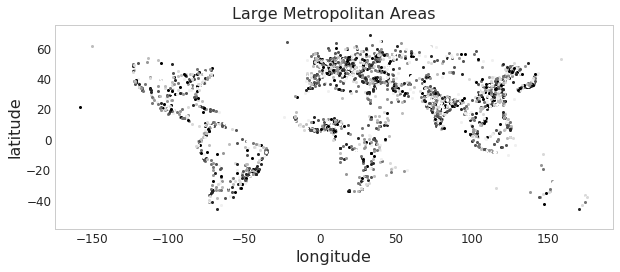

In [21]:
cities_df_sel.plot(figsize=(10,6), cmap='Greys')
plt.title("Large Metropolitan Areas", fontsize=16)
plt.ylabel("latitude", fontsize=16)
plt.xlabel("longitude", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

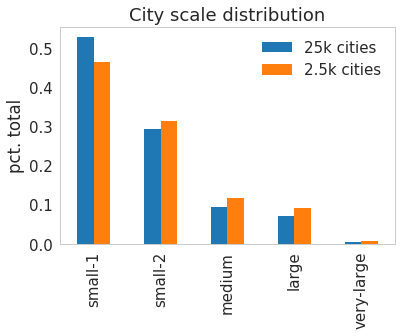

In [30]:
dist_25 = cities_df['scale'].value_counts() / float(len(cities_df))
dist_03 = cities_df_sel['scale'].value_counts() / float(len(cities_df_sel))
scale_df = pd.concat([dist_25, dist_03], axis=1)
scale_df.columns = ["25k cities", "2.5k cities"]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
scale_df.plot(kind="bar")
plt.title("City scale distribution")
plt.ylabel("pct. total")

# Extract city samples

In [31]:
# client for SAR built geometry
sarPath = "/home/data/guf28_merged.tif"
sarFiles = glob.glob(sarPath)
sarImgClient = satimg.SatImage(sarFiles)

(-65.00066738877278, -180.0003314054922, 85.00000094500146, 180.00111704000867)


In [8]:
# client for SAR built geometry
wtrPath = "/home/data/world_water_areas/hydro.tif"
wtrFiles = glob.glob(wtrPath)
wtrImgClient = satimg.SatImage(wtrFiles)

(-65.00416610665006, -180.00416666665018, 75.00416666665006, 180.00416522665017)


In [32]:
# client for nightlights
nliPath = "/home/data/VIIRS/2015/"
nliFiles = glob.glob(nliPath + "/viirs_merged.tif")
nliImgClient = satimg.SatImage(nliFiles)

(-64.99791778665006, -180.00208333335016, 75.00208333335007, 179.9979195466502)


In [33]:
# client for nightlights (old OLS satellite)
nliPath = "/home/data/"
nliFiles = glob.glob(nliPath + "/F16_20100111-20110731_rad_v4.avg_vis.tif")
nliImgClientOld = satimg.SatImage(nliFiles)

(-65.00416610665006, -180.00416666665018, 75.00416666665006, 180.00416522665017)


In [34]:
# client for population density
popPath = "/home/data/landscan-population/LandScan2012/ArcGIS/Population/lspop2012/"
popFiles = glob.glob(popPath + "w001001x.adf")
popImgClient = satimg.SatImage(popFiles)

(-90.00000000000009, -180.00000000000017, 83.9999999999305, 179.9999999998562)


In [3]:
def basic_preprocess(img, res, log=False, scale=True):
    if img is None:
        return None
    img[img<0] = 0
    img = np.ceil(resize(img.squeeze(), (res,res), preserve_range=True))#.astype(int)
    if log:
        img = np.log(img + 1e-3)
    if scale:
        img = (img - img.min()) / (img.max() - img.min())
    return img


#### Plot some examples

In [36]:
nimg = 4
nrow = 4

# smpl_df = cities_df_sel[cities_df_sel['Population']>2e6].sample(nimg).reset_index()

mycities = ["paris, fr", "delhi, in", "san francisco, us", "boston, us"]

smpl_df = cities_df_sel[cities_df_sel['City']\
            .apply(lambda x: sum([s in x for s in mycities])>0)].reset_index()


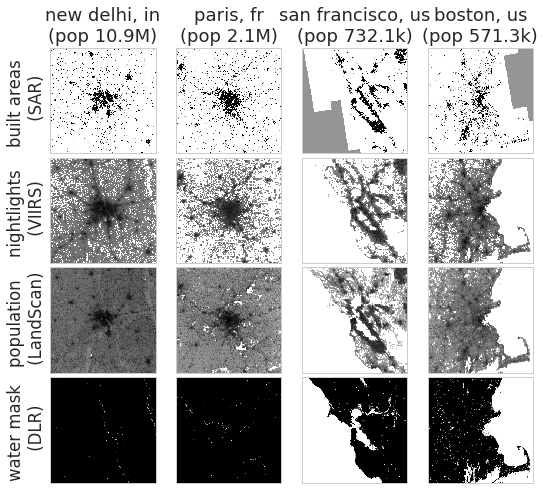

In [46]:
import matplotlib.gridspec as gridspec

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(9,8))
gs1 = gridspec.GridSpec(nrow, nimg)
gs1.update(wspace=0.01, hspace=0.04) # set the spacing between axes. 

for k,(i,r) in enumerate(smpl_df.iterrows()):
    lat, lon, city, pop, country = r['Latitude'], r['Longitude'], r['City'], r['Population'], r['Country']
    # print city, lat, lon, pop, country
    imgSAR = sarImgClient.get_image_at_location((lat, lon), w=200)
    imgSAR = basic_preprocess(imgSAR, 286)
    imgNLI = nliImgClient.get_image_at_location((lat, lon), w=200)
    imgNLI = basic_preprocess(imgNLI, 286, log=True)
    imgWTR = wtrImgClient.get_image_at_location((lat, lon), w=200)
    imgWTR = basic_preprocess(imgWTR, 286)
    imgPOP = popImgClient.get_image_at_location((lat, lon), w=200)
    imgPOP = basic_preprocess(imgPOP, 286, log=True)
    ax0 = plt.subplot(gs1[0,i]); ax0.set_xticks([]); ax0.set_yticks([])
    ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
    ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
    ax3 = plt.subplot(gs1[3,i]); ax3.set_xticks([]); ax3.set_yticks([])
    ax0.imshow(imgSAR,cmap='Greys'); ax0.set_ylabel("built areas \n (SAR)") if i==0 else None
    ax1.imshow(imgNLI,cmap='Greys'); ax1.set_ylabel("nightlights \n (VIIRS)") if i==0 else None
    ax2.imshow(imgPOP,cmap='Greys'); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax3.imshow(imgWTR,cmap='Greys'); ax3.set_ylabel("water mask \n (DLR)") if i==0 else None
    ax0.set_title(city.replace(" (", "\n("))
    

#### Extract  samples: 
* training: all cities > 10k population
* test: filtered cities (by population & location)

In [ ]:
kmScale = 200 # window of 200km width around center
res = 286

# training samples
df = cities_df_all[cities_df_all.Population>10000]
phase = "urban_areas_over_10kpop_log"

cur_dir = outPath + "/%s"%(phase)
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)

from skimage.io import imsave

for i,(idx,r) in enumerate(df.iterrows()):
    imgLat, imgLon = r['Latitude'], r['Longitude']
    city, country = r['City'].replace(" ", "-"), r['Country']
    popNum, popClass = int(r['Population']), r['scale'].replace(" ","-")
    
    clear_output(wait=True)
    print "city %d/%d" % (i, len(df))

    imgSAR = sarImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgSAR = basic_preprocess(imgSAR, res)
    imgNLI = nliImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgNLI = basic_preprocess(imgNLI, res, log=True, scale=False)
    imgNLO = nliImgClientOld.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgNLO = basic_preprocess(imgNLO, res, log=True, scale=False)
    imgWTR = wtrImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgWTR = basic_preprocess(imgWTR, res, scale=True)
    imgPOP = popImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgPOP = basic_preprocess(imgPOP, res, log=True, scale=False)
    if imgSAR is None or imgNLI is None or imgPOP is None or imgWTR is None:
        continue
                       
    # save images to files
    filename = "%s/SAR_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgSAR)
    filename = "%s/NLO_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgNLO)
    filename = "%s/NLI_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgNLI)
    filename = "%s/POP_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgPOP)
    filename = "%s/WTR_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgWTR)

city 20638/25024


In [ ]:
imgSAR